## Set GPU using tensorflow

In [1]:
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.4)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

## Define Keras Model

In [2]:
from keras.layers import Dense,CuDNNLSTM,CuDNNGRU

Using TensorFlow backend.


In [3]:
import matlab.engine
from datetime import datetime
import tensorflow as tf
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Input,Dense, Dropout, BatchNormalization, Activation
from keras import backend as K
from keras.callbacks import Callback
#from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras import optimizers
#from sklearn import linear_model
#from sklearn import preprocessing
import matplotlib.pyplot as plt
#from sklearn.utils import shuffle
from tensorflow import keras
import time
from sklearn.metrics import r2_score
import numpy as np
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

In [4]:
iteration=0
no_of_sources=4
batch_size=1
samples_per_snr=1000
weight_file="source=4_sir"

In [5]:
def matToPyReshape(matArray):
    pyArray=np.zeros((samples_per_snr,16,10))
    for i in range(0,samples_per_snr):
        C=matArray[0,:,i]
        for j in range(1,16):
            C=np.column_stack((C,matArray[j,:,i]))
        pyArray[i,:]=C.T
    return pyArray
    

#### Define a checkpoint callback:

In [6]:
def r_m_s_e(y_true, y_pred):
        print(K.int_shape(y_pred))
   # if no_of_sources==1:
   #     return K.sqrt(K.mean(K.square(K.abs(y_pred-y_true)))) 
   # else:
        total=no_of_sources*batch_size
        
        b=K.repeat_elements(y_true,no_of_sources,axis=0)
        print("b ",K.int_shape(b))
        c=K.repeat_elements(y_pred,no_of_sources,axis=1)
        print(K.int_shape(c))
        c=K.reshape(c,(total,no_of_sources))
        print(K.int_shape(c))
        d=b-c
        print(K.int_shape(d))
        d=K.abs(d)
        mini1=K.min(d,axis=1)
        print(K.int_shape(mini1))
        mini1=K.reshape(mini1,(batch_size,no_of_sources))
        print(K.int_shape(mini1)) 
        return K.sqrt(K.mean(K.square(mini1),axis=-1))

In [7]:
#checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint_name1 = weight_file
checkpoint1 = ModelCheckpoint(checkpoint_name1, monitor="loss", verbose = 1, save_best_only = False, mode ='auto')



In [8]:
#X_train, Y_train = shuffle(X_train, Y_train, random_state=0)

###  Batch normalization after a  & dr1=0.01 dr2=0.1

In [9]:
eng = matlab.engine.start_matlab()

In [10]:
rate=0.001
model = Sequential()
dr=0
#model.add(RepeatVector(16,input_shape=(256,)))

model.add(CuDNNLSTM(128,return_sequences=True,kernel_initializer="glorot_normal",input_shape=(10,32)))
model.add(Dropout(dr))
#model.add(BatchNormalization())
model.add(CuDNNLSTM(128,return_sequences=False,kernel_initializer="glorot_normal"))
model.add(Dropout(dr))
#model.add(BatchNormalization())
#model.add(Dropout(dr))

model.add(Dense(no_of_sources, kernel_initializer='he_normal'))
adam=optimizers.Adam(lr=rate)
model.compile(optimizer=adam, loss=r_m_s_e, metrics=[r_m_s_e])
model.load_weights(weight_file)

callbacks_list = [checkpoint1]
#model.compile(loss='categorical_crossentropy',
              #optimizer='adam', metrics=["accuracy"])


W0909 09:10:43.450442 139902093256448 deprecation_wrapper.py:119] From /home/iiitd/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0909 09:10:43.453151 139902093256448 deprecation_wrapper.py:119] From /home/iiitd/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0909 09:10:43.793907 139902093256448 deprecation_wrapper.py:119] From /home/iiitd/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0909 09:10:44.023962 139902093256448 deprecation_wrapper.py:119] From /home/iiitd/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Ple

(None, 4)
b  (None, None)
(None, 16)
(4, 4)
(4, 4)
(4,)
(1, 4)
(None, 4)
b  (None, None)
(None, 16)
(4, 4)
(4, 4)
(4,)
(1, 4)


In [11]:
def Signal_gen(snr):
    X_real, X_imag, label =eng.doa(snr,samples_per_snr,no_of_sources,nargout=3)
    X_real=np.asarray(X_real)
    X_imag=np.asarray(X_imag)
    label=np.asarray(label)
    a=matToPyReshape(X_real)
    b=matToPyReshape(X_imag)
    X_real_imag=np.zeros((samples_per_snr,32,10))
    for j in range(samples_per_snr):
        X_real_imag[j,]=np.concatenate((a[j,],b[j,]),axis=0)
        
    m=np.zeros((X_real_imag.shape[0],X_real_imag.shape[2],X_real_imag.shape[1]))
    for i in range(X_real_imag.shape[0]):
        for j in range(X_real_imag.shape[2]):
            m[i,j,:]=X_real_imag[i,:,j]
    X_real_imag=m
    
    #PREPROCESSING
    scaler = MinMaxScaler()
    for k in range(X_real_imag.shape[0]):
        X_real_imag[k,:,:]=scaler.fit_transform(X_real_imag[k,:,:])
    return X_real_imag,label

In [12]:
#SNRs=[10.0,15.0,20.0,25.0]
SNRs=[10.0,15.0,20.0,25.0]
while True:
    X_train, y_train=Signal_gen(5.0)
    for snr in SNRs:
        X, y=Signal_gen(snr)
        X_train=np.vstack((X_train,X))
        y_train=np.vstack((y_train,y))
    model.fit(X_train,y_train,epochs=1,callbacks=callbacks_list,verbose=1,batch_size=batch_size,shuffle=False)
    iteration=iteration+1
    print(iteration)

W0909 09:10:51.297130 139902093256448 deprecation.py:323] From /home/iiitd/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 8.4914 - r_m_s_e: 8.4914

Epoch 00001: saving model to source=4_sir
1
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 7.8469 - r_m_s_e: 7.8469

Epoch 00001: saving model to source=4_sir
2
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 7.7826 - r_m_s_e: 7.7826

Epoch 00001: saving model to source=4_sir
3
Epoch 1/1
5000/5000 [==============================] - 18s 4ms/step - loss: 7.3259 - r_m_s_e: 7.3259

Epoch 00001: saving model to source=4_sir
4
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 6.9529 - r_m_s_e: 6.9529

Epoch 00001: saving model to source=4_sir
5
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 7.8834 - r_m_s_e: 7.8834

Epoch 00001: saving model to source=4_sir
6
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 8.6197 - r_m_s_e: 8.6197

Epoch 00001: saving mo

5000/5000 [==============================] - 19s 4ms/step - loss: 9.9559 - r_m_s_e: 9.9559

Epoch 00001: saving model to source=4_sir
56
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 9.7123 - r_m_s_e: 9.7123

Epoch 00001: saving model to source=4_sir
57
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 10.5265 - r_m_s_e: 10.5265

Epoch 00001: saving model to source=4_sir
58
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 9.1980 - r_m_s_e: 9.1980

Epoch 00001: saving model to source=4_sir
59
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 8.9016 - r_m_s_e: 8.9016

Epoch 00001: saving model to source=4_sir
60
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 8.6572 - r_m_s_e: 8.6572

Epoch 00001: saving model to source=4_sir
61
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 9.3929 - r_m_s_e: 9.3929

Epoch 00001: saving mode

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5000/5000 [==============================] - 19s 4ms/step - loss: 8.3261 - r_m_s_e: 8.3261

Epoch 00001: saving model to source=4_sir
127
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 8.9935 - r_m_s_e: 8.9935

Epoch 00001: saving model to source=4_sir
128
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 8.6778 - r_m_s_e: 8.6778

Epoch 00001: saving model to source=4_sir
129
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 8.0887 - r_m_s_e: 8.0887

Epoch 00001: saving model to source=4_sir
130
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 8.3713 - r_m_s_e: 8.3713

Epoch 00001: saving model to source=4_sir
131
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 8.6289 - r_m_s_e: 8.6289

Epoch 00001: saving model to source=4_sir
132
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 8.5367 - r_m_s_e: 8.5367

Epoch 00001: saving 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5000/5000 [==============================] - 19s 4ms/step - loss: 8.4366 - r_m_s_e: 8.4366

Epoch 00001: saving model to source=4_sir
155
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 8.7037 - r_m_s_e: 8.7037

Epoch 00001: saving model to source=4_sir
156
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 8.1816 - r_m_s_e: 8.1816

Epoch 00001: saving model to source=4_sir
157
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 8.5962 - r_m_s_e: 8.5962

Epoch 00001: saving model to source=4_sir
158
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 9.4363 - r_m_s_e: 9.4363

Epoch 00001: saving model to source=4_sir
159
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 8.5350 - r_m_s_e: 8.5350

Epoch 00001: saving model to source=4_sir
160
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 8.6845 - r_m_s_e: 8.6845

Epoch 00001: saving 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5000/5000 [==============================] - 20s 4ms/step - loss: 11.4271 - r_m_s_e: 11.4271

Epoch 00001: saving model to source=4_sir
182
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 9.5694 - r_m_s_e: 9.5694

Epoch 00001: saving model to source=4_sir
183
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 8.2690 - r_m_s_e: 8.2690

Epoch 00001: saving model to source=4_sir
184
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 8.1132 - r_m_s_e: 8.1132

Epoch 00001: saving model to source=4_sir
185
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 7.9637 - r_m_s_e: 7.9637

Epoch 00001: saving model to source=4_sir
186
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 8.4611 - r_m_s_e: 8.4611

Epoch 00001: saving model to source=4_sir
187
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 9.9999 - r_m_s_e: 9.9999

Epoch 00001: savin

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5000/5000 [==============================] - 21s 4ms/step - loss: 8.5125 - r_m_s_e: 8.5125

Epoch 00001: saving model to source=4_sir
208
Epoch 1/1
5000/5000 [==============================] - 21s 4ms/step - loss: 8.9682 - r_m_s_e: 8.9682

Epoch 00001: saving model to source=4_sir
209
Epoch 1/1
5000/5000 [==============================] - 23s 5ms/step - loss: 9.3818 - r_m_s_e: 9.3818

Epoch 00001: saving model to source=4_sir
210
Epoch 1/1
5000/5000 [==============================] - 21s 4ms/step - loss: 9.3774 - r_m_s_e: 9.3774

Epoch 00001: saving model to source=4_sir
211
Epoch 1/1
5000/5000 [==============================] - 21s 4ms/step - loss: 9.4259 - r_m_s_e: 9.4259

Epoch 00001: saving model to source=4_sir
212
Epoch 1/1
5000/5000 [==============================] - 25s 5ms/step - loss: 9.2831 - r_m_s_e: 9.2831

Epoch 00001: saving model to source=4_sir
213
Epoch 1/1
5000/5000 [==============================] - 21s 4ms/step - loss: 8.6750 - r_m_s_e: 8.6750

Epoch 00001: saving 

5000/5000 [==============================] - 21s 4ms/step - loss: 8.0820 - r_m_s_e: 8.0820

Epoch 00001: saving model to source=4_sir
263
Epoch 1/1
5000/5000 [==============================] - 21s 4ms/step - loss: 8.0380 - r_m_s_e: 8.0380

Epoch 00001: saving model to source=4_sir
264
Epoch 1/1
5000/5000 [==============================] - 21s 4ms/step - loss: 7.8752 - r_m_s_e: 7.8752

Epoch 00001: saving model to source=4_sir
265
Epoch 1/1
5000/5000 [==============================] - 21s 4ms/step - loss: 8.2721 - r_m_s_e: 8.2721

Epoch 00001: saving model to source=4_sir
266
Epoch 1/1
5000/5000 [==============================] - 21s 4ms/step - loss: 8.8857 - r_m_s_e: 8.8857

Epoch 00001: saving model to source=4_sir
267
Epoch 1/1
5000/5000 [==============================] - 21s 4ms/step - loss: 7.9342 - r_m_s_e: 7.9342

Epoch 00001: saving model to source=4_sir
268
Epoch 1/1
5000/5000 [==============================] - 21s 4ms/step - loss: 7.6830 - r_m_s_e: 7.6830

Epoch 00001: saving 

5000/5000 [==============================] - 21s 4ms/step - loss: 8.9895 - r_m_s_e: 8.9895

Epoch 00001: saving model to source=4_sir
318
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 8.7966 - r_m_s_e: 8.7966

Epoch 00001: saving model to source=4_sir
319
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 9.0612 - r_m_s_e: 9.0612

Epoch 00001: saving model to source=4_sir
320
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 9.3015 - r_m_s_e: 9.3015

Epoch 00001: saving model to source=4_sir
321
Epoch 1/1
5000/5000 [==============================] - 21s 4ms/step - loss: 8.4577 - r_m_s_e: 8.4577

Epoch 00001: saving model to source=4_sir
322
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 8.4492 - r_m_s_e: 8.4492

Epoch 00001: saving model to source=4_sir
323
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 9.9985 - r_m_s_e: 9.9985

Epoch 00001: saving 

5000/5000 [==============================] - 21s 4ms/step - loss: 8.8595 - r_m_s_e: 8.8595

Epoch 00001: saving model to source=4_sir
373
Epoch 1/1
5000/5000 [==============================] - 21s 4ms/step - loss: 8.4758 - r_m_s_e: 8.4758

Epoch 00001: saving model to source=4_sir
374
Epoch 1/1
5000/5000 [==============================] - 21s 4ms/step - loss: 8.9736 - r_m_s_e: 8.9736

Epoch 00001: saving model to source=4_sir
375
Epoch 1/1
5000/5000 [==============================] - 21s 4ms/step - loss: 9.1887 - r_m_s_e: 9.1887

Epoch 00001: saving model to source=4_sir
376
Epoch 1/1
5000/5000 [==============================] - 21s 4ms/step - loss: 9.0232 - r_m_s_e: 9.0232

Epoch 00001: saving model to source=4_sir
377
Epoch 1/1
5000/5000 [==============================] - 21s 4ms/step - loss: 8.4306 - r_m_s_e: 8.4306

Epoch 00001: saving model to source=4_sir
378
Epoch 1/1
5000/5000 [==============================] - 21s 4ms/step - loss: 9.6117 - r_m_s_e: 9.6117

Epoch 00001: saving 

5000/5000 [==============================] - 21s 4ms/step - loss: 8.0906 - r_m_s_e: 8.0906

Epoch 00001: saving model to source=4_sir
428
Epoch 1/1
5000/5000 [==============================] - 21s 4ms/step - loss: 8.4411 - r_m_s_e: 8.4411

Epoch 00001: saving model to source=4_sir
429
Epoch 1/1
5000/5000 [==============================] - 21s 4ms/step - loss: 8.2977 - r_m_s_e: 8.2977

Epoch 00001: saving model to source=4_sir
430
Epoch 1/1
5000/5000 [==============================] - 22s 4ms/step - loss: 8.0384 - r_m_s_e: 8.0384

Epoch 00001: saving model to source=4_sir
431
Epoch 1/1
5000/5000 [==============================] - 23s 5ms/step - loss: 7.6252 - r_m_s_e: 7.6252

Epoch 00001: saving model to source=4_sir
432
Epoch 1/1
5000/5000 [==============================] - 24s 5ms/step - loss: 8.0159 - r_m_s_e: 8.0159

Epoch 00001: saving model to source=4_sir
433
Epoch 1/1
5000/5000 [==============================] - 23s 5ms/step - loss: 8.5496 - r_m_s_e: 8.5496

Epoch 00001: saving 

5000/5000 [==============================] - 23s 5ms/step - loss: 8.5794 - r_m_s_e: 8.5794

Epoch 00001: saving model to source=4_sir
483
Epoch 1/1
5000/5000 [==============================] - 22s 4ms/step - loss: 8.3576 - r_m_s_e: 8.3576

Epoch 00001: saving model to source=4_sir
484
Epoch 1/1
5000/5000 [==============================] - 22s 4ms/step - loss: 8.4838 - r_m_s_e: 8.4838

Epoch 00001: saving model to source=4_sir
485
Epoch 1/1
5000/5000 [==============================] - 22s 4ms/step - loss: 8.6340 - r_m_s_e: 8.6340

Epoch 00001: saving model to source=4_sir
486
Epoch 1/1
5000/5000 [==============================] - 22s 4ms/step - loss: 8.5645 - r_m_s_e: 8.5645

Epoch 00001: saving model to source=4_sir
487
Epoch 1/1
5000/5000 [==============================] - 22s 4ms/step - loss: 9.0199 - r_m_s_e: 9.0199

Epoch 00001: saving model to source=4_sir
488
Epoch 1/1
5000/5000 [==============================] - 22s 4ms/step - loss: 8.8850 - r_m_s_e: 8.8850

Epoch 00001: saving 

5000/5000 [==============================] - 19s 4ms/step - loss: 7.7119 - r_m_s_e: 7.7119

Epoch 00001: saving model to source=4_sir
538
Epoch 1/1
5000/5000 [==============================] - 21s 4ms/step - loss: 8.4319 - r_m_s_e: 8.4319

Epoch 00001: saving model to source=4_sir
539
Epoch 1/1
5000/5000 [==============================] - 21s 4ms/step - loss: 8.7399 - r_m_s_e: 8.7399

Epoch 00001: saving model to source=4_sir
540
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 9.1415 - r_m_s_e: 9.1415

Epoch 00001: saving model to source=4_sir
541
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 8.5854 - r_m_s_e: 8.5854

Epoch 00001: saving model to source=4_sir
542
Epoch 1/1
5000/5000 [==============================] - 20s 4ms/step - loss: 7.9387 - r_m_s_e: 7.9387

Epoch 00001: saving model to source=4_sir
543
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 7.7515 - r_m_s_e: 7.7515

Epoch 00001: saving 

5000/5000 [==============================] - 23s 5ms/step - loss: 8.7119 - r_m_s_e: 8.7119

Epoch 00001: saving model to source=4_sir
593
Epoch 1/1
5000/5000 [==============================] - 23s 5ms/step - loss: 8.2873 - r_m_s_e: 8.2873

Epoch 00001: saving model to source=4_sir
594
Epoch 1/1
5000/5000 [==============================] - 23s 5ms/step - loss: 9.0208 - r_m_s_e: 9.0208

Epoch 00001: saving model to source=4_sir
595
Epoch 1/1
5000/5000 [==============================] - 23s 5ms/step - loss: 9.8165 - r_m_s_e: 9.8165

Epoch 00001: saving model to source=4_sir
596
Epoch 1/1
5000/5000 [==============================] - 22s 4ms/step - loss: 9.5684 - r_m_s_e: 9.5684

Epoch 00001: saving model to source=4_sir
597
Epoch 1/1
5000/5000 [==============================] - 21s 4ms/step - loss: 8.5140 - r_m_s_e: 8.5140

Epoch 00001: saving model to source=4_sir
598
Epoch 1/1
5000/5000 [==============================] - 21s 4ms/step - loss: 8.3616 - r_m_s_e: 8.3616

Epoch 00001: saving 

5000/5000 [==============================] - 21s 4ms/step - loss: 7.0170 - r_m_s_e: 7.0170

Epoch 00001: saving model to source=4_sir
648
Epoch 1/1
5000/5000 [==============================] - 21s 4ms/step - loss: 6.9747 - r_m_s_e: 6.9747

Epoch 00001: saving model to source=4_sir
649
Epoch 1/1
5000/5000 [==============================] - 21s 4ms/step - loss: 7.0765 - r_m_s_e: 7.0765

Epoch 00001: saving model to source=4_sir
650
Epoch 1/1
5000/5000 [==============================] - 21s 4ms/step - loss: 7.1445 - r_m_s_e: 7.1445

Epoch 00001: saving model to source=4_sir
651
Epoch 1/1
5000/5000 [==============================] - 21s 4ms/step - loss: 7.6489 - r_m_s_e: 7.6489

Epoch 00001: saving model to source=4_sir
652
Epoch 1/1
5000/5000 [==============================] - 21s 4ms/step - loss: 8.3171 - r_m_s_e: 8.3171

Epoch 00001: saving model to source=4_sir
653
Epoch 1/1
5000/5000 [==============================] - 21s 4ms/step - loss: 8.5466 - r_m_s_e: 8.5466

Epoch 00001: saving 

5000/5000 [==============================] - 19s 4ms/step - loss: 8.0391 - r_m_s_e: 8.0391

Epoch 00001: saving model to source=4_sir
703
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 7.6844 - r_m_s_e: 7.6844

Epoch 00001: saving model to source=4_sir
704
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 7.8235 - r_m_s_e: 7.8235

Epoch 00001: saving model to source=4_sir
705
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 7.2614 - r_m_s_e: 7.2614

Epoch 00001: saving model to source=4_sir
706
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 7.2410 - r_m_s_e: 7.2410

Epoch 00001: saving model to source=4_sir
707
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 7.1475 - r_m_s_e: 7.1475

Epoch 00001: saving model to source=4_sir
708
Epoch 1/1
5000/5000 [==============================] - 19s 4ms/step - loss: 8.0622 - r_m_s_e: 8.0622

Epoch 00001: saving 

KeyboardInterrupt: 

### Evaluate the results

In [ ]:
model.load_weights(weight_file)

In [22]:
samples_per_snr=75000

In [23]:
SNRs=[5.0,10.0,15.0,20.0,25.0]
b1=np.zeros((5,))
b2=np.zeros((5,))
i=0
for snr in SNRs:
        X_test, y_test=Signal_gen(snr)
        b1[i]=model.evaluate(X_test,y_test,verbose=0,batch_size=batch_size)[0]
        b2[i]=model.evaluate(X_test,y_test,verbose=0,batch_size=batch_size)[1]
        i=i+1

In [25]:
b1

array([8.42300696, 8.29529771, 8.28299472, 8.23252039, 8.26706113])

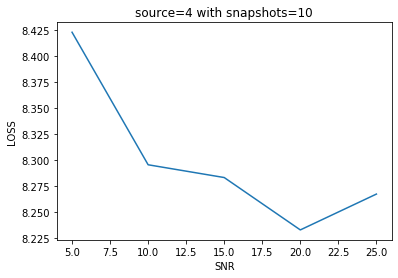

In [24]:
x = np.linspace(5, 25, 5)

plt.plot(x, b2, label='linear')

plt.title('source=4 with snapshots=10')
plt.ylabel('LOSS')
plt.xlabel('SNR')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
source=3 array([8.17313746, 7.33334756, 7.20596606, 7.15551975, 7.1017206 ])
source=2 array([5.58432459, 4.98970056, 4.86629341, 4.87640249, 4.90003241])

In [ ]:
model.save_weights("weight_initialization_sir.hdf5")

In [ ]:
#SNRs=[10.0,15.0,20.0,25.0]
SNRs=[5.0,10.0,15.0,20.0,25.0]
while True:
    for snr in SNRs:
        X, y=Signal_gen(snr)
        loss=model.train_on_batch(X, y)
        print(loss)
    iteration=iteration+1
    print(iteration)

In [ ]:
model.evaluate(X_test[60000:],Y_test[60000:], verbose=0)[0]

In [ ]:
def r_m_s_e(y_true, y_pred):
        print(K.int_shape(y_pred))
   # if no_of_sources==1:
   #     return K.sqrt(K.mean(K.square(K.abs(y_pred-y_true)))) 
   # else:
        total=no_of_sources*batch_size
        
        b=K.repeat_elements(y_true,no_of_sources,axis=0)
        print("b ",K.int_shape(b))
        c=K.repeat_elements(y_pred,no_of_sources,axis=1)
        print(K.int_shape(c))
        c=K.reshape(c,(total,no_of_sources))
        print(K.int_shape(c))
        d=b-c
        print(K.int_shape(d))
        d=K.abs(d)
        mini1=K.min(d,axis=1)
        print(K.int_shape(mini1))
        mini1=K.reshape(mini1,(batch_size,no_of_sources))
        print(K.int_shape(mini1))
        
        return K.sqrt(K.mean(K.square(mini1),axis=-1)) 

In [ ]:
with open('/trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [ ]:
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['r_m_s_e'])
plt.plot(history.history['val_r_m_s_e'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
a=np.arange(24)
a

In [ ]:
a=a.reshape((4,3,2))
a

In [ ]:
b=np.zeros((4,3))

In [ ]:
for i in range(4):
    b[i,]=a[i,:,0]

In [ ]:
b

In [ ]:
a=b

In [ ]:
a

In [ ]:
a[2:]

In [ ]:
from sklearn.utils import shuffle
import numpy as np

X = np.array([[0, 0, 0], [1, 1, 1], [2, 2, 2], [3, 3, 3], [4, 4, 4]])
y = np.array([0, 1, 2, 3, 4])
y=y.reshape((5,1))
X, y = shuffle(X, y)
print(X)
print(y)



In [ ]:
import numpy as np

In [ ]:
X1=np.arange(24)

In [ ]:
X1

In [ ]:
X1=X1.reshape((4,3,2))

In [ ]:
X1

In [ ]:
m=np.zeros((X1.shape[0],X1.shape[2],X1.shape[1]))
for i in range(X1.shape[0]):
    for j in range(X1.shape[2]):
        m[i,j,:]=X1[i,:,j]

In [ ]:
X1=m

In [ ]:
X2=np.arange(24,48)

In [ ]:
X2.shape

In [ ]:
X2=X2.reshape((4,2,3))

In [ ]:
X2

In [ ]:
c=np.vstack((X1,X2))
c.shape

In [ ]:
c

In [ ]:
import numpy as np

In [ ]:
a=np.array([1,2])

In [ ]:
a

In [ ]:
y_pred=K.variable([[1,2,11,30]])
y_true=K.variable([[10,11,30,50]])

In [ ]:
z=K.variable([[y_true[0]-y_pred[0],  y_true[0]-y_pred[1],  y_true[0]-y_pred[2],  y_true[0]-y_pred[3]]])

In [ ]:
K.eval(y_true)

In [ ]:
top=2
y_pred, y_pred_ind_k = tf.nn.top_k(y_pred, top)
y_true, y_true_ind_k = tf.nn.top_k(y_true, top)

In [ ]:
K.eval(y_pred)

In [ ]:
y_true, y_true_ind_k = tf.nn.top_k(y_true, top)

In [ ]:
K.eval(y_true)

In [ ]:
np_y_pred=np.array([1,2,11,30])
np_y_true=np.array([10,11,30,50])

In [ ]:
c=np.zeros((4,))

In [ ]:
one_sided=helper(np_y_pred,np_y_true)
two_sided=helper(np_y_true,np_y_pred)

In [ ]:
one_sided

In [ ]:
two_sided

In [ ]:
combined=np.concatenate([one_sided,two_sided])

In [ ]:
combined

In [ ]:
for i in range(0,4):
    for j in range(0,4):
        a=abs(np_y_true[j]-np_y_pred[i])
        print(a)
        b[j]=a
    c[i]=min(b)

In [ ]:
c

In [ ]:
ker=K.variable(value=combined)

In [ ]:
K.eval(K.sqrt(K.mean(K.square(ker))) )

In [ ]:
K.eval(ker)

In [ ]:
d=K.eval(ker)

In [ ]:
d

In [ ]:
X_real, X_imag, label =eng.Copy_of_doa(5.0,nargout=3)
X_real=np.asarray(X_real)
X_imag=np.asarray(X_imag)
label=np.asarray(label)

In [ ]:
label.shape

In [ ]:
X_real.shape

In [ ]:
y_pred=np.array([[1,2,11,30],
                 [3,4,9,10]])
y_true=np.array([[10,11,30,50],
                 [9,10,11,12]])
y_pred.shape

In [ ]:
y_pred=y_pred.reshape((2,1,4))
y_pred

In [ ]:
one=np.ones((2,4,1))

In [ ]:
b=np.dot(one,y_pred, axes=1)

In [ ]:
b.shape

In [ ]:
b

In [ ]:
a=np.array([[1,2,11,30], [1,2,4,5]])

In [ ]:
b = np.repeat(a, 4, axis=0)

In [ ]:
b

In [ ]:
c=np.array([[10,11,30,50], [5,4,9,10]])

In [ ]:
c=np.array([[10,11,30,50], [5,4,9,10]])
c = np.repeat(c, len(c[0]), axis=1)
print(c)
print(c.shape)

c = c.reshape(8, 4)
print(c)

In [ ]:
d=np.subtract(b,c)

In [ ]:
d=np.abs(d)

In [ ]:
d

In [ ]:
mini=np.min(d, axis=1)

In [ ]:
mini=mini.reshape(2,4)

In [ ]:
mini

In [ ]:
d=d.reshape(2,4,4)

In [ ]:
d

In [ ]:
mini=np.min(d, axis=1)
mini

In [ ]:
no_of_sources=2
batch_size=4

In [ ]:
def r_m_s_e(y_true, y_pred):
        print(K.int_shape(y_pred))
   # if no_of_sources==1:
   #     return K.sqrt(K.mean(K.square(K.abs(y_pred-y_true)))) 
   # else:
        total=no_of_sources*batch_size
        
        b=K.repeat_elements(y_true,no_of_sources,axis=0)
        print("b ",K.int_shape(b))
        c=K.repeat_elements(y_pred,no_of_sources,axis=1)
        print(K.int_shape(c))
        c=K.reshape(c,(total,no_of_sources))
        print(K.int_shape(c))
        d=b-c
        print(K.int_shape(d))
        d=K.abs(d)
        mini1=K.min(d,axis=1)
        print(K.int_shape(mini1))
        mini1=K.reshape(mini1,(batch_size,no_of_sources))
        print(K.int_shape(mini1))
        
        return K.sqrt(K.mean(K.square(mini1),axis=-1)) 

In [ ]:
y_true = K.variable([[10,5],
                    [9,3],
                    [8,7],
                    [6,5]])
y_pred = K.variable([[8,9],
                    [8,4],
                    [9,10],
                    [14,15]])
#Aloss=r_m_s_e(y_true,y_pred)
#print(K.eval(loss))


In [ ]:
K.eval(r_m_s_e(y_true,y_pred))

In [ ]:
y_true.shape

In [ ]:
def mean_np(y_true,y_pred):
    return np.mean(np.square((y_pred-y_true)))

In [ ]:
def mean_squared_error_k(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)

In [ ]:
K.eval(mean_squared_error_k(y_true,y_pred))

In [ ]:
def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred-y_true),axis = -1)

In [ ]:
loss=mean_squared_error(y_true,y_pred)
print(K.eval(loss))


In [ ]:
def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true))

In [ ]:
y=mean_squared_error(y_true,y_pred)

In [ ]:
y.shape

In [ ]:
K.eval(y)